# Web Scraping with requests and Beautiful Soup

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time


In [3]:
url='https://www.basketball-reference.com/players/s/simshe01.html'
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "http://example.com/previous-page",
    "Cookie": "session_id=your_session_id_here",
    "Connection": "keep-alive",
    "Cache-Control": "max-age=0"
}
response = requests.get(url, headers=headers)
status = response.status_code
if status == 200:
    page = response.text
    soup = bs(page)
else:
    print(f"Oops! Received status code {status}")

<!DOCTYPE html>
<html class="no-js" data-root="/home/bbr/build" data-version="klecko-" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport"/>
  <link href="https://cdn.ssref.net/req/202511051" rel="dns-prefetch"/>
  <script>
   /* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
  </script>
  <script src="https://cmp.osano.com/16CGnCU8UtNhM14s
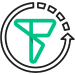
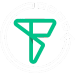

bs4.BeautifulSoup

In [4]:
print(soup.prettify())
type(soup)

### Scrape data from one page and store in a DataFrame

In [5]:
game_stats = [ ]
stats_table = soup.find(class_='stats_table').tbody
#print(stats_table)
for row in stats_table.find_all('tr'):
    mp_cell = row.find('td', {'data-stat': 'mp_per_g'}).text

    
    #print(player)
    pts= row.find(attrs={'data-stat':'pts_per_g'}).text
    game_stats.append({'Minutes Played':mp_cell,'Points':pts})
print(game_stats)

game_state_df = pd.DataFrame(game_stats)

[{'Minutes Played': '2.5', 'Points': '2.0'}, {'Minutes Played': '19.0', 'Points': '7.6'}, {'Minutes Played': '8.4', 'Points': '2.2'}, {'Minutes Played': '27.2', 'Points': '11.8'}, {'Minutes Played': '19.2', 'Points': '8.0'}, {'Minutes Played': '18.8', 'Points': '6.5'}]


In [6]:
game_state_df

,Minutes Played,Points
0,2.5,2.0
1,19.0,7.6
2,8.4,2.2
3,27.2,11.8
4,19.2,8.0
5,18.8,6.5


### Create a function to extract data from one web page so it can be used to extract from multiple pages.
#### This creates a method from the code explored above.

In [7]:
def get_players(soup):
    player_list = [ ]
    stats_table = soup.find(class_='stats_table').tbody
    for row in stats_table.find_all('tr'):
        player = row.find(attrs={'data-stat':'mp_per_g'}).text
        pos= row.find(attrs={'data-stat':'pts_per_g'}).text
        player_list.append({'mp_per_g':player,'pts_per_g':pos})
    return(player_list)

In [8]:
player_df = pd.DataFrame(get_players(soup))
player_df

,mp_per_g,pts_per_g
0,2.5,2.0
1,19.0,7.6
2,8.4,2.2
3,27.2,11.8
4,19.2,8.0
5,18.8,6.5


## Collecting Player Information from Multiple Pages

You will need to create a web scraping pipeline to do this.  Remember the main steps:
1. Gather links -- develop a strategy for scraping past posts
2. Scrape the same data from each page
3. Clean the data as necessary

Save the information as one dictionary for each post and put all the posts in a list called `pipeline_list`. 

In [ ]:
def get_web_page(url):
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        return response.text
    else:
        print(f"Oops! Received status code {status}")
        return ""

In [28]:
import requests
from bs4 import BeautifulSoup, Comment
import time  # <-- for sleep

# Step 1: Get web page function
def get_web_page(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Referer": "http://example.com/previous-page",
        "Cookie": "session_id=your_session_id_here",
        "Connection": "keep-alive",
        "Cache-Control": "max-age=0"
    }
    response = requests.get(url, headers=headers)
    status = response.status_code
    if status == 200:
        return response.text
    else:
        print(f"Oops! Received status code {status}")
        return ""

# Base URLs
base = "https://www.basketball-reference.com"
url_start = f"{base}/players/"

pipeline_list = []  # Final list of player dictionaries

# Step 2: Gather letter links (A–Z)
html = get_web_page(url_start)
soup = BeautifulSoup(html, "html.parser")

# Some content on Basketball Reference is hidden in HTML comments
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

letter_links = []
for c in comments:
    if '/players/' in c:
        comment_soup = BeautifulSoup(c, "html.parser")
        for a in comment_soup.select("a[href^='/players/']"):
            href = a.get("href")
            # e.g. '/players/a/' — exactly 11 chars long
            if href and len(href) == 11:
                letter_links.append(base + href)

print(f"Found {len(letter_links)} letter pages.")

# Step 3: Gather all player links from A–Z pages
player_links = []

for letter_url in letter_links:
    page = get_web_page(letter_url)
    soup = BeautifulSoup(page, "html.parser")

    # Each player is linked in a table under <th data-stat='player'>
    for a in soup.select("th[data-stat='player'] a"):
        href = a.get("href")
        if href:
            player_links.append(base + href)
    
    # Sleep 1 second between letter pages
    time.sleep(1)

print(f"Collected {len(player_links)} player profile links.")

# Step 4: Scrape player data from each player page
for i, url in enumerate(player_links[:5]):  # limit to first 50 to be polite
    html = get_web_page(url)
    soup = BeautifulSoup(html, "html.parser")

    # Scrape the data
    name = soup.find("h1").find("span").text.strip() if soup.find("h1") else "N/A"

    position_tag = soup.find("p")
    position = "N/A"

        # Find all <p> tags
    p_tags = soup.find_all("p")
    
    position = "N/A"
    weight = None
    
    for p in p_tags:
        text = p.get_text(" ", strip=True)
    
        # Look for the Position paragraph
        if "Position:" in text:
            # Extract the position only (between "Position:" and "Shoots:")
            position = (
                text.split("Position:")[1]
                .split("Shoots:")[0]
                .split("▪")[0]
                .strip()
            )
    
        # Look for the Height/Weight paragraph
        if "lb" in text:
            spans = p.find_all("span")
            if len(spans) > 1:
                weight_text = spans[1].text.strip()
                if "lb" in weight_text:
                    weight = int(weight_text.replace("lb", "").strip())


        # Find all <td> tags with data-stat="mp_per_g"
        minute_tags = soup.find_all("td", {"data-stat": "mp_per_g"})
        
        # Extract the text values and convert to float
        minutes_played = [float(tag.text.strip()) for tag in minute_tags if tag.text.strip()]

        # Find all <td> tags with data-stat="pts_per_g"
        ppg_tags = soup.find_all("td", {"data-stat": "pts_per_g"})
        
        # Extract the text values and convert to float
        points_per_game = [float(tag.text.strip()) for tag in ppg_tags if tag.text.strip()]
        
                
        # Find all free throw per game values
        fta_tags = soup.find_all("td", {"data-stat": "fta_per_g"})
        free_throws = []
        
        for tag in fta_tags:
            text = tag.text.strip()
            if text:  # skip empty cells
                try:
                    free_throws.append(float(text))
                except ValueError:
                    pass  # ignore non-numeric text
        
        # Ensure it’s at least one value (Career or last season)
        if not free_throws:
            free_throws = [0]  # fallback if nothing found

        
        # Blocks per game (latest season)
        blk_tags = soup.find_all("td", {"data-stat": "blk_per_g"})
        blocks = float(blk_tags[-1].text.strip()) if blk_tags and blk_tags[-1].text.strip() else 0
        
        # Total games played
        total_games = 0
        
        # Find the span with Games label
        games_label = soup.find("span", {"class": "poptip", "data-tip": "Games"})
        if games_label:
            # The number is in the next <p> tag
            p_tag = games_label.find_next("p")
            if p_tag and p_tag.text.strip().isdigit():
                total_games = int(p_tag.text.strip())





        player_dict = {
        "name": name,
        "position": position,
        "weight": weight,
        "minutes played": minutes_played,
        "points": points_per_game,
        "free_throws": free_throws,
        "blocks": blocks,
        "total_games": total_games
    }
    pipeline_list.append(player_dict)

    # Optional: progress update
    if i % 1 == 0:
        print(f"Processed {i+1}/{len(player_links)} players...")

    # Sleep 1.5 seconds between player requests
    time.sleep(2)

# Step 5: Review collected data
print(f"\nTotal players scraped: {len(pipeline_list)}")
print(pipeline_list[:5])  # Show first few player dictionaries


Found 25 letter pages.
Collected 5372 player profile links.
Processed 1/5372 players...
Processed 2/5372 players...
Processed 3/5372 players...
Processed 4/5372 players...
Processed 5/5372 players...

Total players scraped: 5
[{'name': 'Alaa Abdelnaby', 'position': 'Power Forward', 'weight': 240, 'minutes played': [6.7, 13.2, 17.5, 13.3, 18.3, 12.2, 9.4, 9.3, 10.0, 12.5, 10.7, 17.3, 9.3, 13.3, 10.0, 2.6, 3.1, 17.0, 6.2, 2.9, 17.0], 'points': [3.1, 6.1, 7.7, 5.3, 8.2, 4.9, 4.7, 5.0, 0.7, 5.7, 5.0, 7.6, 5.0, 5.3, 0.7, 0.8, 1.5, 5.5, 2.2, 1.2, 5.5], 'free_throws': [1.0, 1.4, 1.5, 1.3, 1.6, 1.9, 0.6, 0.7, 0.0, 1.3, 1.3, 1.6, 0.7, 1.3, 0.0, 0.0, 0.5, 0.0, 0.2, 0.3, 0.0], 'blocks': 0.3, 'total_games': 0}, {'name': 'Zaid Abdul-Aziz', 'position': 'Center and Power Forward', 'weight': 235, 'minutes played': [19.3, 5.4, 28.9, 20.5, 20.9, 30.7, 18.8, 31.1, 22.3, 8.3, 8.9, 9.9, 12.0, 9.6, 21.8, 24.0, 22.5, 22.7, 8.9, 5.4, 12.0, 11.7, 11.3, 12.0, 11.7, 11.7, 11.3, 12.0], 'points': [7.3, 1.9, 11.0, 

In [29]:
import pandas as pd

# Convert list of player dictionaries to DataFrame
df = pd.DataFrame(pipeline_list)

# Standardize column names to avoid spaces/case issues
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# --- Compute averages for list-based or single-value stats ---
for col, new_col in [
    ("minutes_played", "avg_minutes"),
    ("points", "avg_points"),
    ("free_throws", "avg_free_throws"),
    ("blocks", "avg_blocks")
]:
    if col in df.columns:
        df[new_col] = df[col].apply(
            lambda x: round(sum(x)/len(x), 1) if isinstance(x, list) and len(x) > 0
            else round(float(x), 1) if x is not None else 0
        )
    else:
        df[new_col] = 0

# Drop the original list or raw columns (except total_games)
for col in ["minutes_played", "points", "free_throws", "blocks"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# --- Ensure numeric columns are proper types ---
numeric_cols = ["weight", "avg_minutes", "avg_points", "avg_free_throws", "avg_blocks"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Convert total_games to numeric but do not modify it otherwise
if "total_games" in df.columns:
    df["total_games"] = pd.to_numeric(df["total_games"], errors='coerce').fillna(0).astype(int)

# --- Clean string columns ---
string_cols = ["name", "position", "url"]
for col in string_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# --- Optional: reorder columns ---
cols_order = [
    "name", "position", "weight", "avg_minutes", "avg_points",
    "avg_free_throws", "avg_blocks", "total_games", "url"
]
df = df[[c for c in cols_order if c in df.columns]]

# --- Display the cleaned DataFrame ---
df.head()


,name,position,weight,avg_minutes,avg_points,avg_free_throws,avg_blocks,total_games
0,Alaa Abdelnaby,Power Forward,240,11.0,4.4,0.8,0.3,0
1,Zaid Abdul-Aziz,Center and Power Forward,235,15.9,6.6,2.1,1.0,0
2,Kareem Abdul-Jabbar,Center,225,38.0,25.1,6.1,2.4,0
3,Mahmoud Abdul-Rauf,Point Guard,162,25.2,13.3,2.1,0.1,0
4,Tariq Abdul-Wahad,Shooting Guard,223,18.2,6.7,2.0,0.8,0
